In [2]:
!pip install google-play-scraper

from google_play_scraper import app, reviews, Sort, reviews_all

import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
seed = 0
np.random.seed(seed)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

import datetime as dt
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

!pip install sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from wordcloud import WordCloud

import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')

import time
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import csv
import requests
from io import StringIO
from wordcloud import WordCloud
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.3 MB/s eta 0:00:00


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
app_id = 'id.dana'
total_reviews = 50000
batch_size = 10000
review_df = []


while len(review_df) < total_reviews:
    try:
        result, _ = reviews(
            app_id,
            lang='id',
            country='id',
            sort=Sort.MOST_RELEVANT,
            count=batch_size,
            continuation_token=None if not review_df else token
        )
        review_df.extend(result)
        token = _
        print(f"Jumlah review terkumpul: {len(review_df)}")
        time.sleep(1)
    except Exception as e:
        print("Terjadi error:", e)
        break


Jumlah review terkumpul: 10000
Jumlah review terkumpul: 20000
Jumlah review terkumpul: 30000
Jumlah review terkumpul: 40000
Jumlah review terkumpul: 50000


In [4]:
df = pd.DataFrame(review_df)
df = df[['at','userName', 'score', 'content']]
df.to_csv('ulasan_aplikasi.csv', index=False)

print("Total review yang disimpan:", len(df))

Total review yang disimpan: 50000


In [5]:
df = pd.read_csv("ulasan_aplikasi.csv")

In [6]:
app_reviews_df = df.copy()

In [7]:
app_reviews_df.head()

,at,userName,score,content
0,2025-03-29 16:56:30,Pengguna Google,2,mengapa sangat sulit mengganti KTP padahal sem...
1,2025-03-27 18:49:41,Pengguna Google,1,Emang aplikasi BUSUK.Saya transaksi sudah terj...
2,2025-04-08 10:18:29,Pengguna Google,2,kurangin bintang nya ga bisa di buka kalo jari...
3,2025-04-08 23:00:03,Pengguna Google,3,"Dulu sbnrnya ini apk bgs, tapi lama lama error..."
4,2025-04-03 05:24:42,Pengguna Google,1,"Akun tiba"" terhubung ke UC Drive Premium, Sald..."


In [8]:
# Menampilkan informasi tentang DataFrame app_reviews_df
app_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   at        50000 non-null  object
 1   userName  50000 non-null  object
 2   score     50000 non-null  int64 
 3   content   50000 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.5+ MB


In [9]:
clean_df = app_reviews_df.dropna()

In [10]:
clean_df = clean_df.drop_duplicates()

jumlah_ulasan_setelah_hapus_duplikat, jumlah_kolom_setelah_hapus_duplikat = clean_df.shape

In [11]:
app_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   at        50000 non-null  object
 1   userName  50000 non-null  object
 2   score     50000 non-null  int64 
 3   content   50000 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.5+ MB


#Preprocessing Text

In [12]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r'RT[\s]', '', text)
    text = re.sub(r"http\S+", '', text)
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'[^\w\s]', '', text)

    text = text.replace('\n', ' ')
    text = text.replace('.', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip(' ')
    return text

def casefoldingText(text):
    text = text.lower()
    return text

def tokenizingText(text):
    text = word_tokenize(text)
    return text

def filteringText(text):
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(text):

    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    words = text.split()

    stemmed_words = [stemmer.stem(word) for word in words]

    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

def toSentence(list_words):
    sentence = ' '.join(word for word in list_words)
    return sentence

In [13]:
slangwords = {
    "bgs": "bagus",
    "mantul": "mantap betul",
    "mdh": "mudah",
    "ok": "oke",
    "sip": "oke",
    "top": "bagus",
    "jos": "mantap",
    "mantap": "bagus",
    "cepet": "cepat",
    "cepattt": "cepat",
    "trs": "terus",
    "oke": "bagus",
    "puas": "puas",
    "suka": "suka",
    "keren": "keren",
    "praktis": "praktis",
    "hemat": "hemat",
    "lancar": "lancar",
    "recommended": "rekomendasi",
    "rekomen": "rekomendasi",
    "trmksh": "terima kasih",
    "terimakasih": "terima kasih",
    "tq": "terima kasih",
    "jlk": "jelek",
    "jelek": "jelek",
    "buruk": "buruk",
    "lemot": "lambat",
    "lelet": "lambat",
    "lola": "lambat",
    "error": "error",
    "gagal": "gagal",
    "hang": "hang",
    "crash": "crash",
    "parah": "buruk",
    "tipu": "penipuan",
    "penipu": "penipuan",
    "penipuan": "penipuan",
    "bug": "bug",
    "riput": "ribet",
    "ribet": "ribet",
    "susah": "sulit",
    "sulit": "sulit",
    "tidak bisa": "tidak bisa",
    "gak bisa": "tidak bisa",
    "gak jelas": "tidak jelas",
    "tdk jelas": "tidak jelas",
    "hilang": "hilang",
    "delay": "terlambat",
    "bohong": "penipuan",
    "ditolak": "gagal",
    "ngeblank": "blank",
    "bikin kesel": "mengecewakan",
    "ngaco": "buruk",
    "nggak nyala": "tidak bisa digunakan",
    "dana": "Dana",
}

def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [14]:
clean_df['text_clean'] = clean_df['content'].apply(cleaningText)

clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(casefoldingText)

clean_df['text_slangwords'] = clean_df['text_casefoldingText'].apply(fix_slangwords)

clean_df['text_tokenizingText'] = clean_df['text_slangwords'].apply(tokenizingText)

clean_df['text_stopword'] = clean_df['text_tokenizingText'].apply(filteringText)

clean_df['text_akhir'] = clean_df['text_stopword'].apply(toSentence)

In [15]:
clean_df

,at,userName,score,content,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir
0,2025-03-29 16:56:30,Pengguna Google,2,mengapa sangat sulit mengganti KTP padahal sem...,mengapa sangat sulit mengganti KTP padahal sem...,mengapa sangat sulit mengganti ktp padahal sem...,mengapa sangat sulit mengganti ktp padahal sem...,"[mengapa, sangat, sulit, mengganti, ktp, padah...","[sulit, mengganti, ktp, persyaratan, terpenuhi...",sulit mengganti ktp persyaratan terpenuhi vide...
1,2025-03-27 18:49:41,Pengguna Google,1,Emang aplikasi BUSUK.Saya transaksi sudah terj...,Emang aplikasi BUSUKSaya transaksi sudah terja...,emang aplikasi busuksaya transaksi sudah terja...,emang aplikasi busuksaya transaksi sudah terja...,"[emang, aplikasi, busuksaya, transaksi, sudah,...","[emang, aplikasi, busuksaya, transaksi, berhas...",emang aplikasi busuksaya transaksi berhasil bu...
2,2025-04-08 10:18:29,Pengguna Google,2,kurangin bintang nya ga bisa di buka kalo jari...,kurangin bintang nya ga bisa di buka kalo jari...,kurangin bintang nya ga bisa di buka kalo jari...,kurangin bintang nya ga bisa di buka kalo jari...,"[kurangin, bintang, nya, ga, bisa, di, buka, k...","[kurangin, bintang, buka, kalo, jaringan, data...",kurangin bintang buka kalo jaringan data mah p...
3,2025-04-08 23:00:03,Pengguna Google,3,"Dulu sbnrnya ini apk bgs, tapi lama lama error...",Dulu sbnrnya ini apk bgs tapi lama lama error ...,dulu sbnrnya ini apk bgs tapi lama lama error ...,dulu sbnrnya ini apk bagus tapi lama lama erro...,"[dulu, sbnrnya, ini, apk, bagus, tapi, lama, l...","[sbnrnya, apk, bagus, error, isi, saldo, error...",sbnrnya apk bagus error isi saldo error tf err...
4,2025-04-03 05:24:42,Pengguna Google,1,"Akun tiba"" terhubung ke UC Drive Premium, Sald...",Akun tiba terhubung ke UC Drive Premium Saldo ...,akun tiba terhubung ke uc drive premium saldo ...,akun tiba terhubung ke uc drive premium saldo ...,"[akun, tiba, terhubung, ke, uc, drive, premium...","[akun, terhubung, uc, drive, premium, saldo, t...",akun terhubung uc drive premium saldo terpoton...
...,...,...,...,...,...,...,...,...,...,...
49995,2025-01-14 01:08:50,NOVI ARDANA,5,aplikasi dana sangat membantu untuk tf di mana...,aplikasi dana sangat membantu untuk tf di mana...,aplikasi dana sangat membantu untuk tf di mana...,aplikasi Dana sangat membantu untuk tf di mana...,"[aplikasi, Dana, sangat, membantu, untuk, tf, ...","[aplikasi, Dana, membantu, tf, lpun]",aplikasi Dana membantu tf lpun
49996,2019-11-15 20:12:48,Pengguna Google,1,"Saya baru pake aplikasi ini, karna ada kepenti...",Saya baru pake aplikasi ini karna ada kepentin...,saya baru pake aplikasi ini karna ada kepentin...,saya baru pake aplikasi ini karna ada kepentin...,"[saya, baru, pake, aplikasi, ini, karna, ada, ...","[pake, aplikasi, karna, kepentingan, kerjaan, ...",pake aplikasi karna kepentingan kerjaan downlo...
49997,2023-04-10 15:29:46,Raja Malam,1,Ini gimana si dulu mudah mudah aja masuk akun ...,Ini gimana si dulu mudah mudah aja masuk akun ...,ini gimana si dulu mudah mudah aja masuk akun ...,ini gimana si dulu mudah mudah aja masuk akun ...,"[ini, gimana, si, dulu, mudah, mudah, aja, mas...","[gimana, si, mudah, mudah, aja, masuk, akun, D...",gimana si mudah mudah aja masuk akun Dana suli...
49998,2021-05-07 21:27:09,Ahmad Saipullah,1,Lama bener ni lelet. Udh di wa antrian selalu ...,Lama bener ni lelet Udh di wa antrian selalu p...,lama bener ni lelet udh di wa antrian selalu p...,lama bener ni lambat udh di wa antrian selalu ...,"[lama, bener, ni, lambat, udh, di, wa, antrian...","[bener, ni, lambat, udh, wa, antrian, penuh, d...",bener ni lambat udh wa antrian penuh ditanggap...


#PELABELAN

In [16]:
lexicon_positive = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')

if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')
    for row in reader:
        lexicon_positive[row[0]] = int(row[1])
else:
    print("Failed to fetch positive lexicon data")

lexicon_negative = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')

if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')
    for row in reader:
        lexicon_negative[row[0]] = int(row[1])
else:
    print("Failed to fetch negative lexicon data")

def analyze_sentiment(text, threshold=1):
    score = 0
    words = text.lower().split()

    for word in words:
        if word in lexicon_positive:
            score += lexicon_positive[word]
        elif word in lexicon_negative:
            score -= lexicon_negative[word]

    if score > threshold:
        return "positif"
    elif score < -threshold:
        return "negatif"
    else:
        return "netral"

In [17]:
def sentiment_analysis_lexicon_indonesia(text):

    score = 0

    for word in text:

        if (word in lexicon_positive):
            score = score + lexicon_positive[word]

    for word in text:

        if (word in lexicon_negative):
            score = score + lexicon_negative[word]

    polarity=''

    if (score >= 0.5):
        polarity = 'positive'
    elif (score < -0.5):
        polarity = 'negative'
    else:
        polarity = 'neutral'

    return score, polarity

In [18]:
results = clean_df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
clean_df['polarity_score'] = results[0]
clean_df['polarity'] = results[1]
print(clean_df['polarity'].value_counts())

polarity
negative    28452
positive    18228
neutral      3320
Name: count, dtype: int64


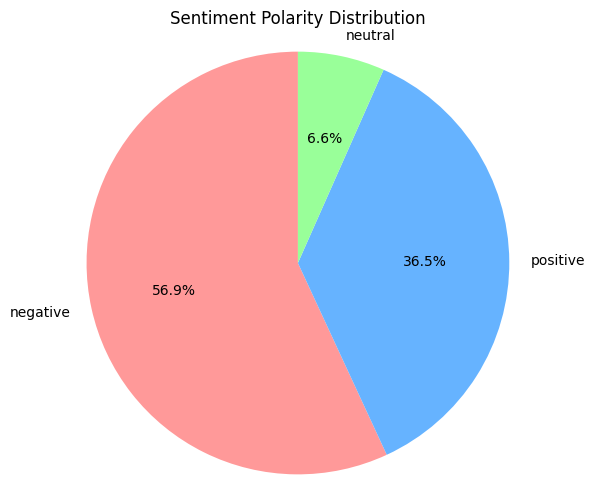

In [19]:
polarity_counts = clean_df['polarity'].value_counts()

plt.figure(figsize=(6,6))
plt.pie(polarity_counts, labels=polarity_counts.index, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff','#99ff99'])
plt.title('Sentiment Polarity Distribution')
plt.axis('equal')
plt.show()

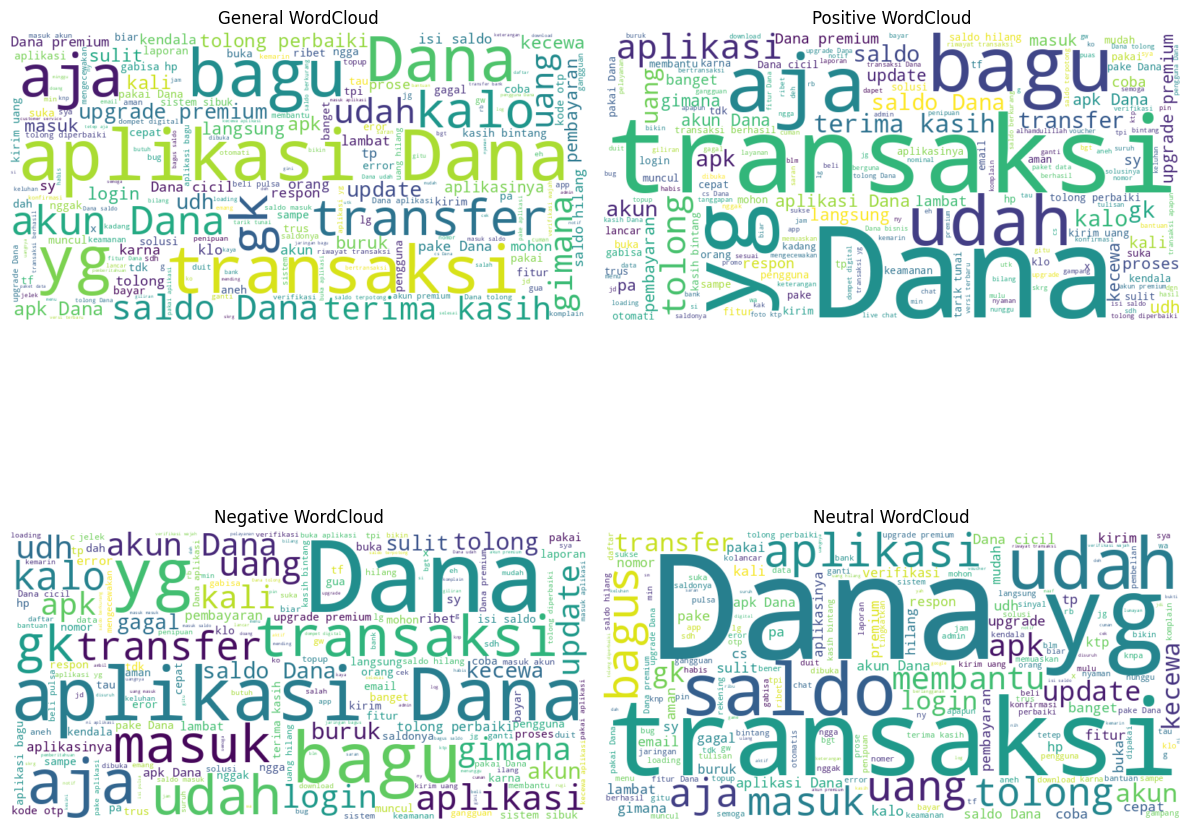

In [20]:
def list_to_string(text_list):
    return " ".join(text_list) if isinstance(text_list, list) else text_list

text_all = " ".join(clean_df['text_stopword'].apply(list_to_string))  # Ensure text is a string
wordcloud_all = WordCloud(width=800, height=400, background_color='white').generate(text_all)

text_positive = " ".join(clean_df[clean_df['polarity'] == 'positive']['text_stopword'].apply(list_to_string))
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(text_positive)

text_negative = " ".join(clean_df[clean_df['polarity'] == 'negative']['text_stopword'].apply(list_to_string))
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(text_negative)

text_neutral = " ".join(clean_df[clean_df['polarity'] == 'neutral']['text_stopword'].apply(list_to_string))
wordcloud_neutral = WordCloud(width=800, height=400, background_color='white').generate(text_neutral)

fig, axes = plt.subplots(2, 2, figsize=(12, 12))

axes[0, 0].imshow(wordcloud_all, interpolation='bilinear')
axes[0, 0].axis('off')
axes[0, 0].set_title('General WordCloud')

axes[0, 1].imshow(wordcloud_positive, interpolation='bilinear')
axes[0, 1].axis('off')
axes[0, 1].set_title('Positive WordCloud')

axes[1, 0].imshow(wordcloud_negative, interpolation='bilinear')
axes[1, 0].axis('off')
axes[1, 0].set_title('Negative WordCloud')

axes[1, 1].imshow(wordcloud_neutral, interpolation='bilinear')
axes[1, 1].axis('off')
axes[1, 1].set_title('Neutral WordCloud')

plt.tight_layout()
plt.show()


#Eksport Dataset

In [21]:
clean_df.to_csv('clean_dataset.csv', index=False)

print("Dataset akhir telah diekspor ke dataset_akhir.csv")

Dataset akhir telah diekspor ke dataset_akhir.csv
